<a href="https://colab.research.google.com/github/Smartsie/Optimizer/blob/master/Optimizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Optim package

# **Functionnalities to be added**
1.   Models should be listed in a dictionnary. Each model is defined by it's function or class with train, predict and score 
2.   During fitting, we will score all models. The highest score will then be used for the prediction
3. This could be done by doing a voting of top 3 best models with a 3,2,1 weight for instance







In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [4]:
import plotly as py
from keras.layers import Dense
import lightgbm
import plotly.express as px

Using TensorFlow backend.


In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(random_state=0)
#gpr.score(X, y)
#gpr.predict(X[:2,:], return_std=True)
# Define model that will be used to minimize the function
# Simple NN
import tensorflow.keras
from tensorflow.keras.models import Sequential
from xgboost import XGBRegressor
#def def_model():
    # define the keras model
    # it returns a compile model
#model = Sequential()
#model.add(Dense(5, input_dim=(2), activation='relu'))
    #model.add(Dense(4))
    #model.add(Dense(8, activation='relu'))
#model.add(Dense(1, activation='linear'))
#model.compile(loss='mae', optimizer='sgd', metrics=['accuracy'])
#   return model
model=XGBRegressor()
#model=lightgbm.LGBMRegressor()

In [0]:
# If we want to export in html in a separate browser
import plotly.io as pio
#pio.renderers.default = "browser" 

In [0]:
α=1

In [0]:
# Define function to minimize
def funct(x):
#    f=x1*x1+x2*x2-x1*x2+5*np.sin(x1*2)+4*np.cos(x2*2)
    x1=x[0]
    x2=x[1]
    #f=x1*x1+x1*x2+2*np.sin((x1+x2)*2)+4*np.cos(x2*2)
    x=x1
    y=x2
    # Lévi function
    f=(np.sin(3*3.1415*x))**2+(x-1)**2*(1+(np.sin(3*3.1415*y))**2)+(y-1)**2*(1+(np.sin(2*3.1415*y))**2)
    
    return f

In [0]:
# Define function providing 5 points around 
def next_point(current_space,n=5):
    next_space=current_space
    pt=pd.DataFrame()
    for i in range(n):
        vecteur=current_space['Center']
        Radius=current_space['Radius']
        new_vec=vecteur+Radius*np.random.choice((-1,1),size=len(Radius))*np.random.random(len(Radius))
        for j in range(len(new_vec)):
            if new_vec[j]<space.iloc[j]['Center']-space.iloc[j]['Radius']:
                new_vec[j]=space.iloc[j]['Center']-space.iloc[j]['Radius']
            if new_vec[j]>space.iloc[j]['Center']+space.iloc[j]['Radius']:
                new_vec[j]=space.iloc[j]['Center']+space.iloc[j]['Radius']                              
        pt['n'+str(i)]=new_vec
    pt=pt.T
    pt.columns=X.drop('target',axis=1).columns
    #next_space['Radius']=next_space['Radius']*epsilon
    return pt,next_space
        

In [0]:
# This function adds the points to the matrix
# The matrix is a dataframe
def add_matrix(X,points):
    df=points
    for i in range(len(df)):
        variables=df.iloc[i]
        variables['target']=funct(variables)
        X=X.append(variables)
    return X

In [0]:
def training_loop(X,domain,AI=False,n=5,epsilon=0.95):
    df,new_space=next_point(domain,n)
    Matrix=add_matrix(X,df)
    x=Matrix.drop('target',axis=1).values
    y=Matrix['target'].values
    if AI==True:
        #model.fit(x,y,epochs=100,verbose=False)
        # Need to do a CV split with Train test split
        model.fit(x,y)
        #print('Model score',model.score(x,y))
        # find minimum in design space
        # Predict and find the minimum in one shot
        Prediction=model.predict(srf_x.values)
        lowest_value=np.min(Prediction)
        minimum=srf.iloc[np.argmin(Prediction)]        
    else:
        theor_min=np.argmin(X.target.values)
        lowest_value=np.min(X.target.values)
        minimum=X.iloc[theor_min]
    minimum=minimum.drop('target')
    # New space should be centered around this minimum
    domain['Center']=(minimum.values*0.5+domain.Center*0.5)
    domain['Radius']=new_space['Radius']*epsilon
    return Matrix,domain,lowest_value

In [0]:
# Define the design space as center point with radius

x0range=[-10,10]
x1range=[-10,10]

space=pd.DataFrame(columns=['Center','Radius'])
space.loc[0]=[np.mean(x0range),0.5*(x0range[1]-x0range[0])]
space.loc[1]=[np.mean(x1range),0.5*(x1range[1]-x1range[0])]


# Initialize X matrix
X=pd.DataFrame()
for i in range(len(space)):
    X['x'+str(i)]=0
X['target']=0
# Fill X with 5 points
X['x0']=[x0range[0],x0range[0],x0range[1],x0range[1],(x0range[0]+x1range[1])/2,(x0range[0]+x1range[1])/2,(x0range[0]+x1range[1])/2,x0range[0],x0range[1]]
X['x1']=[x1range[0],x1range[1],x1range[0],x1range[1],(x0range[0]+x1range[1])/2,x1range[0],x1range[1],(x0range[0]+x1range[1])/2,(x0range[0]+x1range[1])/2]
for i in range(len(X)):
    variables=X.iloc[i]
    variables['target']=funct(variables)
    X.iloc[i]['target']=variables.target

# Initialize domain
domain=space.copy()



In [0]:
# Check Surface
srf=pd.DataFrame()
x_space=pd.DataFrame(columns=X.columns)
#visualize surface with random N points
# Fill the x_space with N points
N_samples=10000
for i in range(len(space)):
    vect=np.random.uniform(space.iloc[i][0]-space.iloc[i][1],space.iloc[i][0]+space.iloc[i][1],N_samples)
    srf['x'+str(i)]=vect
srf['target']=0
for i in range(len(srf)):
    val=funct(srf.iloc[i])
    srf['target'].iloc[i]=val
srf_x=srf.drop('target',axis=1)  

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
#fig = px.scatter_3d(srf, x='x0', y='x1', z='target',color='target')
#fig.show()
print("Minimum : ",np.min(srf.target))
print(srf.iloc[np.argmin(srf.target)])

Minimum :  0.12317626819522973
x0        1.032424
x1        1.139223
target    0.123176
Name: 2439, dtype: float64


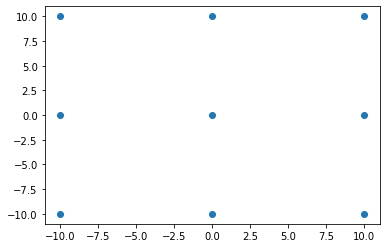

In [0]:
plt.scatter(X['x0'],X['x1'])

In [0]:
# Run the training loop
N=10
Max_points=10
Dom=[] #pd.DataFrame(columns=['x0 C','x0 R','x1 C','x1 R'])]
for i in range(N):
    # Point amound should decrease. At the beginning, it should be 10. At the end, 2.
    point_amount=np.int((Max_points-3)-(Max_points-3)*i/N)+3
    X,domain,minimum=training_loop(X,domain,AI=True,n=point_amount,epsilon=0.8)
    #Dom=np.append(Dom,[i,domain.loc[0].values])
    vect=[i, domain.loc[0].values[0],domain.loc[0].values[1],domain.loc[1].values[0],domain.loc[1].values[1]]
    Dom.append(vect)
Dom=pd.DataFrame(Dom,columns=['idx','x0 C','x0 R','x1 C','x1 R'])

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[09:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [0]:
point_amount

3

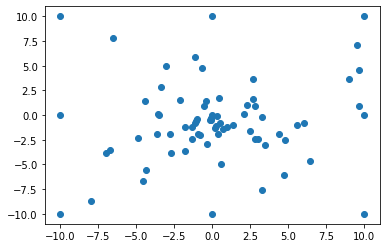

In [0]:
plt.scatter(X['x0'],X['x1'])

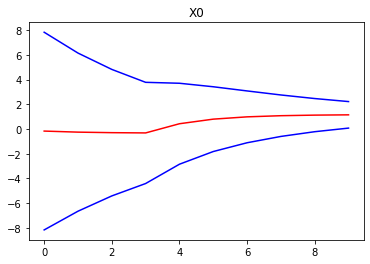

In [0]:
plt.plot(Dom.idx,Dom['x0 C'],color='red')
plt.plot(Dom.idx,Dom['x0 C']+Dom['x0 R'],color='blue')
plt.plot(Dom.idx,Dom['x0 C']-Dom['x0 R'],color='blue')
plt.title('X0')
plt.show()

We can see that that there is *stable* convergence on X0

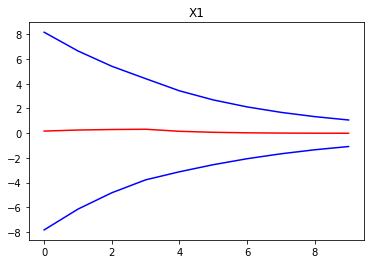

In [0]:
plt.plot(Dom.idx,Dom['x1 C'],color='red')
plt.plot(Dom.idx,Dom['x1 C']+Dom['x1 R'],color='blue')
plt.plot(Dom.idx,Dom['x1 C']-Dom['x1 R'],color='blue')
plt.title('X1')
plt.show()

However, X1 is **unstable** as it is bouncing abruptly

In [0]:
# Print Minimum found
min=np.min(X.target.values)
print(min)
print("For X=")
print(X.iloc[np.argmin(X.target.values)])

1.8440879480701957
For X=
x0        2.285464
x1        0.997341
target    1.844088
Name: n5, dtype: float64


In [0]:
print("Total Experiments")
print(len(X))

Total Experiments
73


In [0]:
Prediction=model.predict(srf_x.values)

In [0]:
modelresult=srf_x.copy()
modelresult['target']=Prediction

In [0]:
fig = px.scatter_3d(modelresult, x='x0', y='x1', z='target',color='target',title='Model Result')
fig.show()

In [0]:
fig = px.scatter_3d(srf, x='x0', y='x1', z='target',color='target',title='Actual data')
fig.show()

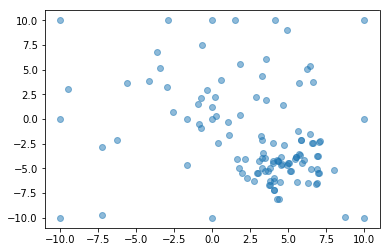

In [0]:
plt.scatter(X['x0'],X['x1'],alpha=0.5)

In [0]:
print("Theoretical minimum from surface")
print(srf.iloc[np.argmin(srf.z)])

In [0]:
# How to find minimum?
# 1 Define design space
x_space=[-5,5]
y_space=[-5,5]
# Define space Matrix
N_points=50*50
n=np.sqrt(N_points)
X_space=pd.DataFrame(columns=['x1','x2'])

In [0]:
def training_loop(current_x_space,current_y_space, AI=False):
    #def train_model(X,model):
    x=X[['x','y']].values
    y=X['z'].values
    if AI==True:
        #model.fit(x,y,epochs=100,verbose=False)
        model.fit(x,y)
        print('Model score',model.score(x,y))
        # find minimum in design space
        # Predict and find the minimum in one shot
        minimum=X_space.iloc[np.argmin(model.predict(X_space.values))]
    else:
        theor_min=np.argmin([funct(X_space.iloc[i][0],X_space.iloc[i][1]) for i in range(0,len(X_space))])
        minimum=X_space.iloc[theor_min]
    cx=np.mean(current_x_space)
    cy=np.mean(current_y_space)
    # focus point
    fx=minimum[0]
    fy=minimum[1]
    rangex=current_x_space[1]-current_x_space[0]
    rangey=current_y_space[1]-current_y_space[0]
    # divide the range by 2
    rangex=rangex/3
    rangey=rangey/3
    new_rangex=[(fx+cx)/2-rangex,(fx+cx)/2+rangex]
    new_rangey=[(fy+cy)/2-rangey,(fy+cy)/2+rangey]
#    new_rangey=[minimum[0]-rangey,minimum[0]+rangey]
    points=provide_point(new_rangex,new_rangey,noise=False)
    add_matrix(points)
    current_x_space=new_rangex
    current_y_space=new_rangey  
    return current_x_space,current_y_space

In [0]:
#Define Matrix of results
X=pd.DataFrame(columns=['x','y','z'])
points=provide_point(x_space,y_space,noise=False)
add_matrix(points)
points=provide_point(x_space,y_space,noise=True)
add_matrix(points)
current_x_space=x_space
current_y_space=y_space
print(X)

In [0]:
# Fin the best point by doing training
A=[]
B=[]
for i in range(0,10):
    current_x_space,current_y_space= training_loop(current_x_space,current_y_space,AI=True)
    A.append(current_x_space)
    B.append(current_y_space)

In [0]:
A=pd.DataFrame(A,columns=['xmin','xmax'])
B=pd.DataFrame(B,columns=['ymin','ymax'])
A.plot()
B.plot()
plt.show()
plt.plot(X.x,X.y)
plt.title('Convergence')
plt.xlabel('x1')
plt.ylabel('x2')
plt.grid()
plt.show()

In [0]:
print("Theoretical minimum from surface")
print(srf.iloc[np.argmin(srf.z)])
# Calculate min value of X
theor=np.argmin(X.z.values)
minimum=X.iloc[theor]
print("Estimated minimum by solver:")
print(minimum)

In [0]:
X_space['z']=model.predict(X_space[['x1','x2']].values)

In [0]:
fig1 = px.scatter_3d(srf, x='x1', y='x2', z='z')
fig2 = px.scatter_3d(X_space, x='x1', y='x2', z='z',color='z')
fig2.show()

In [0]:
fig1 = px.scatter_3d(srf, x='x1', y='x2', z='z',color='z')
fig1.show()

In [0]:
trace1 = go.Scatter3d(
    x=srf.x1,
    y=srf.x2,
    z=srf.z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217,0 , 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)




In [0]:
trace2 = go.Scatter3d(
    x=X_space.x1,
    y=X_space.x2,
    z=X_space.z,
    mode='markers',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(0, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)


In [0]:
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

In [0]:
import chart_studio.plotly as py

In [0]:
fig = go.Figure(data=[go.Scatter3d(x=X.x.values, y=X.y.values, z=X.z.values,
                                   mode='markers')])
fig.show()

In [0]:
fig = px.scatter_3d(srf, x='x1', y='x2', z='z',color='z')


fig.show()

In [0]:
fig = px.scatter_3d(X_space, x='x1', y='x2', z='z',color='z')


fig.show()